In [3]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo", torch_dtype=torch.float32)
pipe.to("cuda")

for i in range(10):
    prompt = "A cinematic shot of a baby racoon wearing an intricate italian priest robe."
    image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

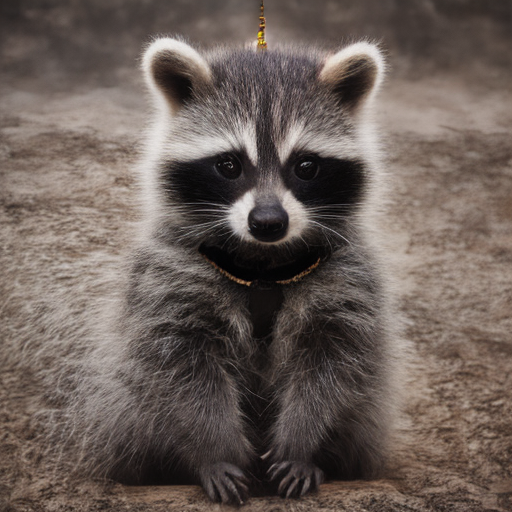

In [2]:
image

In [2]:
# Load model in gpu with onnxruntime
import sys
import numpy as np

if not '.' in sys.path:
    sys.path.append('.')

from freewillai.common import NonTuringModel

class NonTuringModelFromPath(NonTuringModel):
    def __init__(self, path):
        self.path = path
        self.lib = 'onnx'

onnx_path = '/tmp/model.onnx'
onnx_model = NonTuringModelFromPath(onnx_path)
data = {
    "bedrooms": 3,
    "bathrooms": 1,
    "sqft_living": 200,
    "sqft_lot": 3362,
    "floors": 5,
    "waterfront": 1,   # 0 or 1
    "view": 0,         # 0 or 1
    "condition": 1,    # 5 is best, 1 is worst
    "sqft_above": 1050,
    "sqft_basement": 90,
    "yr_built": 2023
}
data = np.array([list(data.values())])

onnx_model.inference(data)

dataset=array([[   3,    1,  200, 3362,    5,    1,    0,    1, 1050,   90, 2023]])
[DEBUG] inference in CPU


array([[289203.7]], dtype=float32)

In [7]:
import os
os.environ['GPU'] = '1'
onnx_model.inference(data)

dataset=array([[   3,    1,  200, 3362,    5,    1,    0,    1, 1050,   90, 2023]])
[DEBUG] inference in CPU
[DEBUG] inference in GPU
[DEBUG] GPU with more free space 0, 8358199296


/home/nico/micromamba/envs/fwai/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


array([[289203.7]], dtype=float32)

In [16]:
import onnxruntime as rt
providers = [
    ('CUDAExecutionProvider', {
        'device_id': 0,
        # 'arena_extend_strategy': 'kNextPowerOfTwo',
        'gpu_mem_limit': 8 * 1024**3,
        # 'cudnn_conv_algo_search': 'EXHAUSTIVE',
        'do_copy_in_default_stream': True,
    }),
    'CPUExecutionProvider',
]
inference_sess = rt.InferenceSession(onnx_path, providers=providers)
input_name = inference_sess.get_inputs()[0].name
label_name = inference_sess.get_outputs()[0].name
preds = inference_sess.run(
    [label_name], {input_name: data.astype(np.float32)}
)
print(preds)

[array([[289203.7]], dtype=float32)]


In [17]:
!pip install -q optimum["onnxruntime"]

In [ ]:
from optimum.onnxruntime import ORTStableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipeline = ORTStableDiffusionPipeline.from_pretrained(model_id, export=True)
# prompt = "sailing ship in storm by Leonardo da Vinci"
# image = pipeline(prompt).images[0]
pipeline.save_pretrained("./onnx-stable-diffusion-v1-5")

In [ ]:
!optimum-cli export onnx --model runwayml/stable-diffusion-v1-5 sd_v15_onnx/

Framework not specified. Using pt to export to ONNX.
Keyword arguments {'subfolder': '', 'trust_remote_code': False} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...:   0%|                     | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|█████████████| 7/7 [00:00<00:00,  7.12it/s]
Automatic task detection to stable-diffusion.
Using framework PyTorch: 2.1.2+cu121
/home/nico/.local/lib/python3.10/site-packages/transformers/modeling_attn_mask_utils.py:86: TracerWarning: Converting a tensor to a Python boolean might ca